In [1]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
from orbitflows.integrate import hamiltonian_fixed_angle
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import torch
from orbitflows import H
from time import time

In [2]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

In [3]:
model = HamiltonianMappingModel(targetPotential=isoDiskPotential, input_dim=2, hidden_dim=10, num_layers=4)
model.flow = model.flow.double()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_18085/3416017122.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/TensorShape.cpp:3687.)
  plt.scatter(*training_data.T, s=10)



Text(0.5, 1.0, 'Toy Orbits')

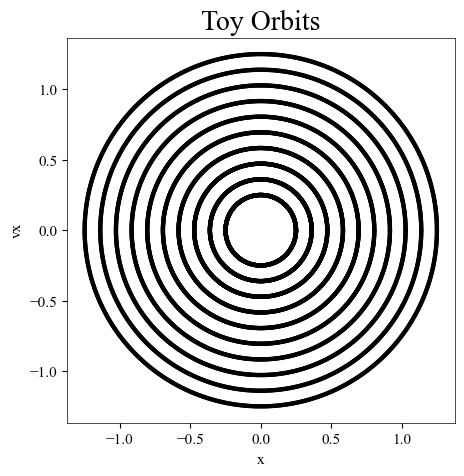

In [4]:
n_actions = 10
n_angles = 1000
r_min = 0.25
r_max = 1.25
omega_guess = 1
training_data, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=2*np.pi, n_steps=n_angles, r_bounds=[r_min,r_max])
aa_guess = aa_guess.to(torch.float64)
training_data = training_data.to(torch.float64)

# plot training data
plt.figure(figsize=(5, 5))
plt.scatter(*training_data.T, s=10)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('Toy Orbits', fontsize=20)

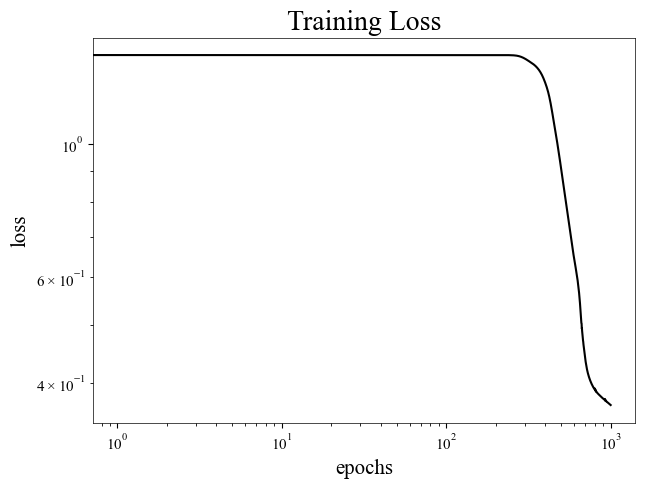

Text(0, 0.5, 'energy')

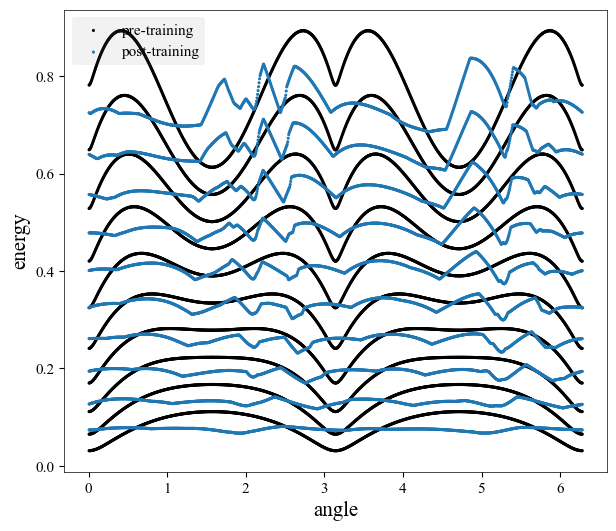

In [ ]:
# train model
steps = 1000
model.train(training_data.to(torch.float64), steps, lr=1e-3)

# plot loss
plt.figure(figsize=(7, 5))
plt.loglog(model.loss_list)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title('Training Loss', fontsize=20)
plt.show()

# # plot performance for one orbit
# plt.figure(figsize=(8, 5))
# plt.plot(aa_guess[0][...,0].detach(), model.hamiltonian(aa_guess[0]).detach())
# plt.plot(aa_guess[0][...,0].detach(), np.repeat(model.hamiltonian(aa_guess[0]).mean().detach(), len(aa_guess[0][...,0].detach())), 'r--')
# plt.xlabel('time', fontsize=15)
# plt.ylabel('energy', fontsize=15)
# plt.title('model performance', fontsize=20)
# plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(7, 6))
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)

In [6]:
aa0 = aa_guess[5][0].requires_grad_(True)
ps0 = model.aa_to_ps(aa0).requires_grad_(True)

# Numerical Derivative Test

In [7]:
from orbitflows.integrate import dH_dx

In [8]:
def h_error(model, ps):
    '''
    Compute the error of the model prediction in the Hamiltonian.
    
    Parameters
    ----------
    ps : torch.tensor
        phase-space point
    
    Returns
    -------
    torch.tensor
        Hamiltonian error of the model prediction
    '''
    _aa = model.ps_to_aa(ps)
    return H(ps, model.targetPotential) - hamiltonian_fixed_angle(model, _aa)

In [9]:
eps_float64 = torch.finfo(torch.float64).eps
eps_float32 = torch.finfo(torch.float32).eps
ps_eps = ps0 + torch.tensor([0.0, eps_float64])

In [10]:
# wrt p


eps = torch.finfo(torch.float64).eps**0.5# * ps0[1] #**2  # A good choice for numerical differentiation
ps_h = ps0.clone()
ps_h[1] += eps  # Add epsilon to p component

# Calculate difference
h_error_ps0 = partial(h_error, model)(ps0)
h_error_ps_h = partial(h_error, model)(ps_h)
numerical_derivative = (h_error_ps_h - h_error_ps0) / eps

# Print results
print(f"Step size (eps): {eps}")
print(f"h_error at p: {h_error_ps0.item():.10f}")
print(f"h_error at p+h: {h_error_ps_h.item():.10f}")
print(f"Numerical derivative dH_dp: {numerical_derivative.item():.10f}")

# Compare with the analytical derivative
analytical_derivative = dH_dx(ps0, 'p', partial(h_error, model)).item()
print(f"Analytical derivative dH_dp: {analytical_derivative:.10f}")
print(f"Difference: {abs(numerical_derivative.item() - analytical_derivative):.10e}")

# Check if the model and input tensors are in the same precision
# print(f"Model flow dtype: {model.flow.dtype}")
print(f"ps0 dtype: {ps0.dtype}")
print(f"h_error output dtype: {partial(h_error, model)(ps0).dtype}")

Step size (eps): 1.4901161193847656e-08
h_error at p: -0.0065546409
h_error at p+h: -0.0065546417
Numerical derivative dH_dp: -0.0554655753
Analytical derivative dH_dp: -0.0554655836
Difference: 8.2599409534e-09
ps0 dtype: torch.float64
h_error output dtype: torch.float64


In [11]:
# wrt q


eps = torch.finfo(torch.float64).eps**0.5# * ps0[1] #**2  # A good choice for numerical differentiation
ps_h = ps0.clone()
ps_h[0] += eps  # Add epsilon to p component

# Calculate difference
h_error_ps0 = partial(h_error, model)(ps0)
h_error_ps_h = partial(h_error, model)(ps_h)
numerical_derivative = (h_error_ps_h - h_error_ps0) / eps

# Print results
print(f"Step size (eps): {eps}")
print(f"h_error at q: {h_error_ps0.item():.10f}")
print(f"h_error at q+h: {h_error_ps_h.item():.10f}")
print(f"Numerical derivative dH_dq: {numerical_derivative.item():.10f}")

# Compare with the analytical derivative
analytical_derivative = - dH_dx(ps0, 'q', partial(h_error, model)).item()
print(f"Analytical derivative dH_dq: {analytical_derivative:.10f}")
print(f"Difference: {abs(numerical_derivative.item() - analytical_derivative):.10e}")

# Check if the model and input tensors are in the same precision
# print(f"Model flow dtype: {model.flow.dtype}")
print(f"ps0 dtype: {ps0.dtype}")
print(f"h_error output dtype: {partial(h_error, model)(ps0).dtype}")

Step size (eps): 1.4901161193847656e-08
h_error at q: -0.0065546409
h_error at q+h: -0.0065546418
Numerical derivative dH_dq: -0.0612433292
Analytical derivative dH_dq: -0.0612433280
Difference: 1.2055464405e-09
ps0 dtype: torch.float64
h_error output dtype: torch.float64


## Using Jacobian

In [20]:
torch.autograd.functional.jacobian(partial(h_error, model), (ps0))[0].item() + dH_dx(ps0, 'q', partial(h_error, model)).item()

0.0

## Checking with gradcheck

In [14]:
torch.autograd.gradcheck(partial(dH_dx, wrt='p', _hamiltonian=partial(h_error, model)), ps0)

GradcheckError: Numerical gradient for function expected to be zero

In [15]:
split_dH_dq = lambda q, p : partial(dH_dx, wrt='q', _hamiltonian=partial(h_error, model))(torch.stack((q, p), dim=-1))
split_dH_dp = lambda q, p : partial(dH_dx, wrt='p', _hamiltonian=partial(h_error, model))(torch.stack((q, p), dim=-1))

In [16]:
split_dH_dq(ps0[0], ps0[1]) - dH_dx(ps0, 'q', partial(h_error, model)), split_dH_dp(ps0[0], ps0[1]) - dH_dx(ps0, 'p', partial(h_error, model))

(tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [17]:
torch.autograd.gradcheck(split_dH_dq, (ps0[0], ps0[1]))

GradcheckError: Numerical gradient for function expected to be zero

it's the same as autograd.grad

In [21]:
dH_dx(ps0, 'q', partial(h_error, model)).item(), dH_dx(ps0, 'p', partial(h_error, model))

(0.06124332799162191, tensor(-0.0555, dtype=torch.float64))

In [ ]:
torch.autograd.grad(